<a href="https://colab.research.google.com/github/Ptuancuong/TH-TimeSeries.csv/blob/main/Retail_Sales_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
a = 2251262584%20 +1
a

5

In [5]:
import pandas as pd

df = pd.read_csv('us-retail-sales.csv', parse_dates=['Month'])
df.set_index('Month', inplace=True)
df.index.freq = 'MS'
df['Total_Sales'] = df.sum(axis=1)

print(df.head())

            Clothing  Appliances  FoodAndBeverage  Automobiles  \
Month                                                            
1992-01-01      6938        3657            29589        26788   
1992-02-01      7524        3490            28570        28203   
1992-03-01      8475        3669            29682        31684   
1992-04-01      9401        3527            30228        32547   
1992-05-01      9558        3571            31677        32883   

            GeneralMerchandise  BuildingMaterials  Total_Sales  
Month                                                           
1992-01-01               14996               8964        90932  
1992-02-01               16015               9023        92825  
1992-03-01               17984              10608       102102  
1992-04-01               18872              11630       106205  
1992-05-01               20037              12327       110053  


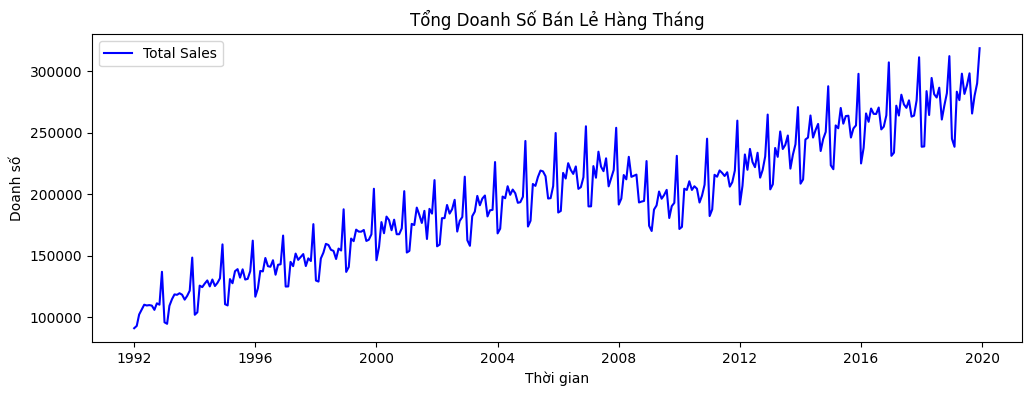

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df['Total_Sales'], label='Total Sales', color='blue')
plt.title('Tổng Doanh Số Bán Lẻ Hàng Tháng')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.legend()
plt.show()


In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Total_Sales'])
print('ADF Statistic: %.4f' % result[0])
print('p-value: %.4f' % result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.4f' % (key, value))


ADF Statistic: -0.7990
p-value: 0.8194
Critical Value (1%): -3.4509
Critical Value (5%): -2.8706
Critical Value (10%): -2.5716


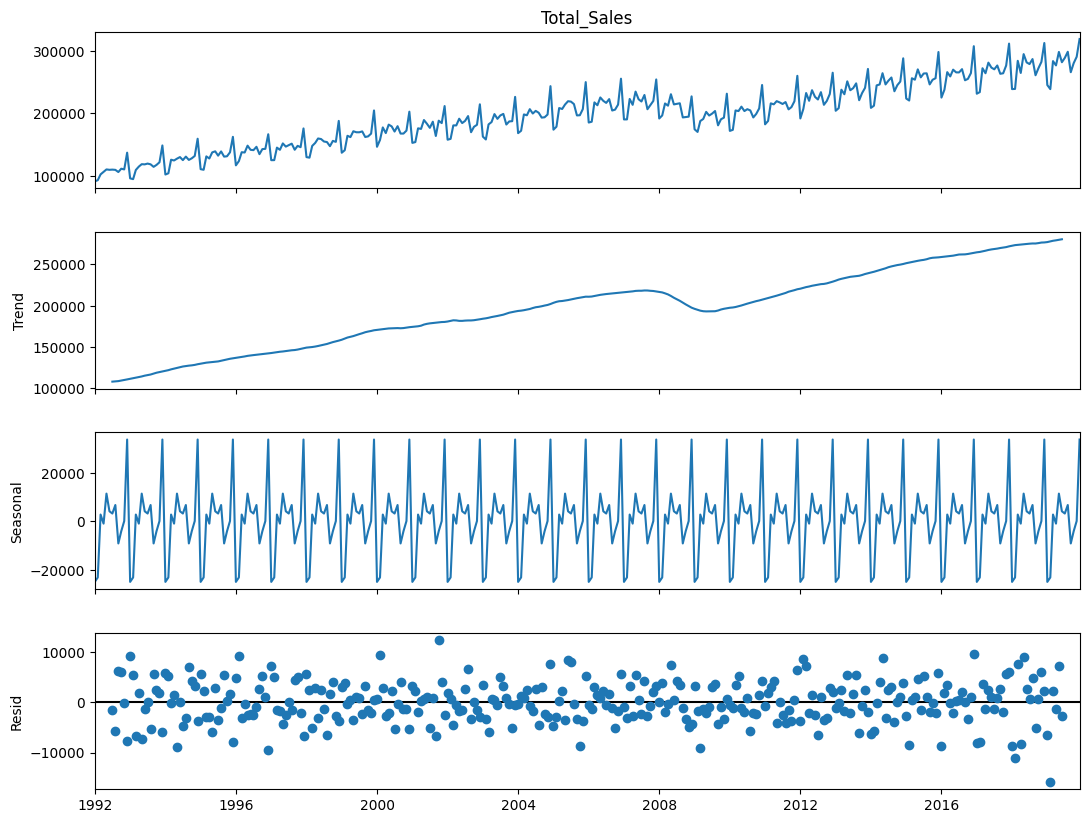

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Total_Sales'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 9)
plt.show()


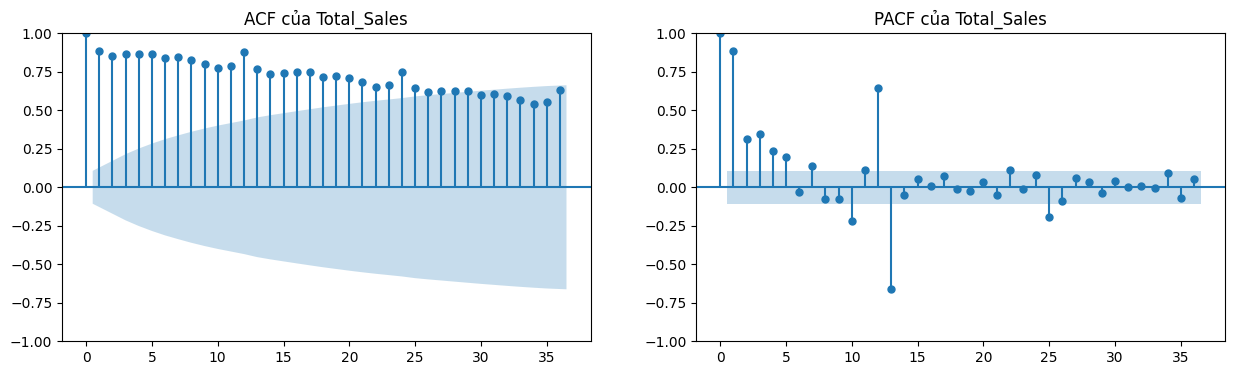

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df['Total_Sales'], lags=36, ax=axes[0])
plot_pacf(df['Total_Sales'], lags=36, ax=axes[1])
axes[0].set_title('ACF của Total_Sales')
axes[1].set_title('PACF của Total_Sales')
plt.show()


In [10]:
# Sai phân non-seasonal (d = 1)
df_diff = df['Total_Sales'].diff().dropna()

# Tiếp tục sai phân seasonal (D = 1, s = 12)
df_seasonal_diff = df_diff.diff(12).dropna()

# Kiểm tra lại tính dừng sau khi đã sai phân cả hai
result_diff = adfuller(df_seasonal_diff)
print('Sau sai phân (d=1, D=1, s=12):')
print('ADF Statistic: %.4f' % result_diff[0])
print('p-value: %.4f' % result_diff[1])


Sau sai phân (d=1, D=1, s=12):
ADF Statistic: -5.6556
p-value: 0.0000


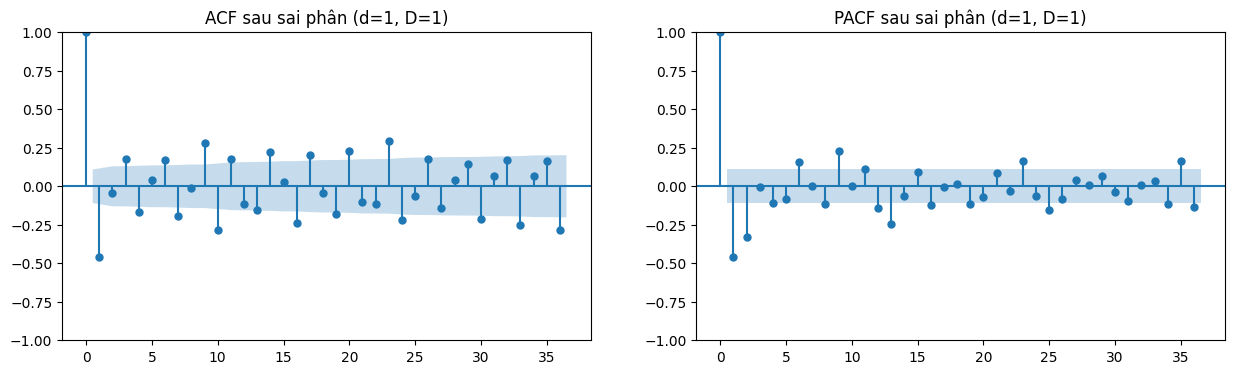

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df_seasonal_diff, lags=36, ax=axes[0])
plot_pacf(df_seasonal_diff, lags=36, ax=axes[1])
axes[0].set_title('ACF sau sai phân (d=1, D=1)')
axes[1].set_title('PACF sau sai phân (d=1, D=1)')
plt.show()


In [13]:
# Dùng 24 tháng cuối làm test, phần còn lại làm train
train = df['Total_Sales'][:-24]
test = df['Total_Sales'][-24:]


In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        Total_Sales   No. Observations:                  312
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2807.659
Date:                            Tue, 03 Jun 2025   AIC                           5625.318
Time:                                    06:45:17   BIC                           5643.580
Sample:                                01-01-1992   HQIC                          5632.639
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1409      0.111     -1.270      0.204      -0.358       0.077
ma.L1         -0.4779      0.095   

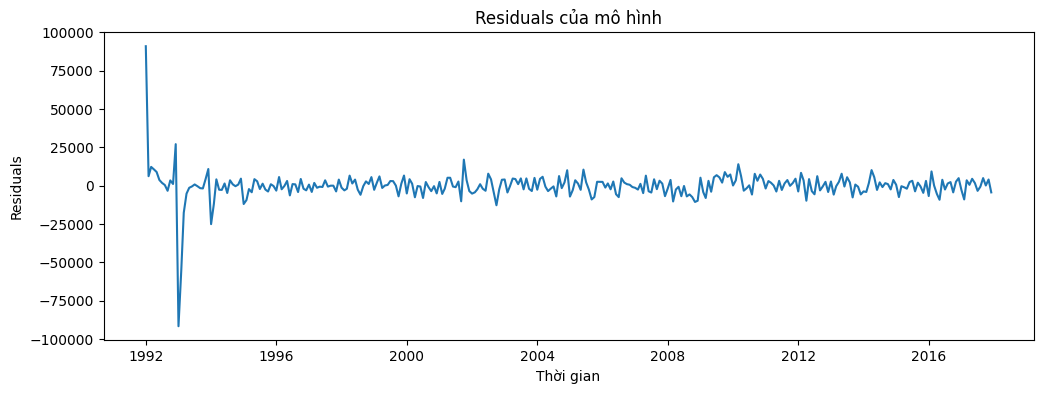

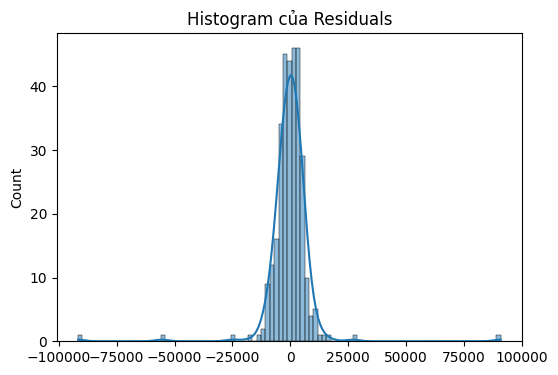

<Figure size 600x400 with 0 Axes>

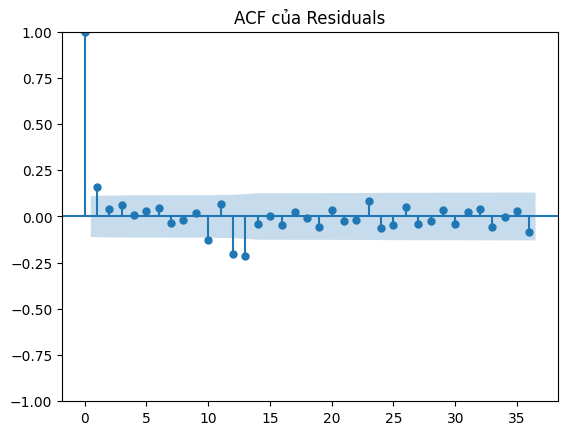

In [15]:
import seaborn as sns

residuals = results.resid

plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals của mô hình')
plt.xlabel('Thời gian')
plt.ylabel('Residuals')
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title('Histogram của Residuals')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(6, 4))
plot_acf(residuals, lags=36)
plt.title('ACF của Residuals')
plt.show()


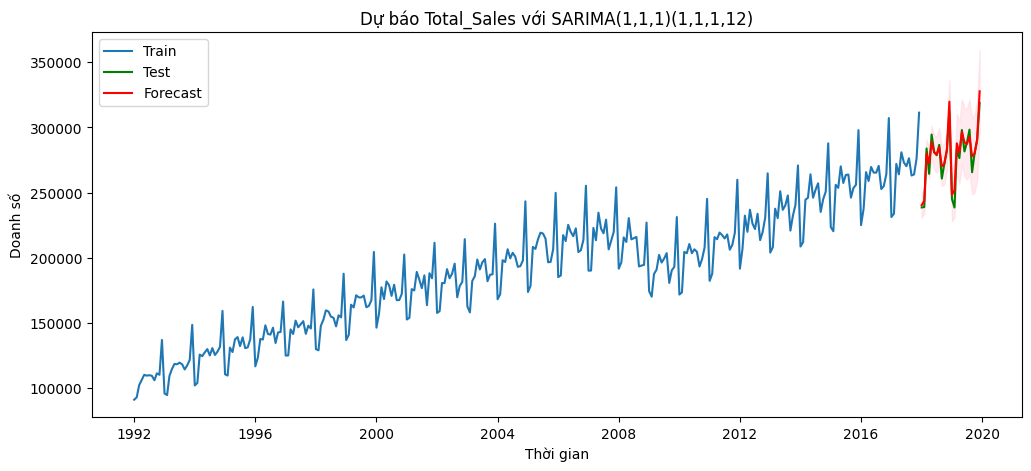

In [16]:
forecast = results.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Vẽ kết quả dự báo so với thực tế
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('Dự báo Total_Sales với SARIMA(1,1,1)(1,1,1,12)')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, forecast_mean)
print(f'Mean Squared Error (MSE) trên tập Test: {mse:.2f}')


Mean Squared Error (MSE) trên tập Test: 34810348.06


In [18]:
print("Mean của Train:", train.mean())
print("Std của Train:", train.std())
print("Mean của Test:", test.mean())
print("Std của Test:", test.std())


Mean của Train: 190327.15384615384
Std của Train: 47327.23158119692
Mean của Test: 277444.1666666667
Std của Test: 21631.728811223544


In [19]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(test, forecast_mean)
rmse = np.sqrt(mse)
print(f'RMSE trên tập Test: {rmse:.2f}')


RMSE trên tập Test: 5900.03


In [20]:
print("Biến thiên (Std) của Train:", train.std())
print("Biến thiên (Std) của Test:", test.std())


Biến thiên (Std) của Train: 47327.23158119692
Biến thiên (Std) của Test: 21631.728811223544


In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Giả sử 'train' và 'test' đã được định nghĩa như sau:
# train = df['Total_Sales'][:-24]
# test  = df['Total_Sales'][-24:]

# 1. Tạo một array hoặc Series trống để chứa kết quả naive forecast
#    Đảm bảo nó có cùng index với 'test'
naive_pred = pd.Series(index=test.index, dtype=float)

# 2. Giá trị dự báo của tháng đầu test = tháng cuối train
naive_pred.iloc[0] = train.iloc[-1]

# 3. Từ vị trí thứ 2 trở đi, dùng test.shift(1)
#    (lấy trực tiếp các giá trị của chính 'test' lùi 1 tháng)
naive_pred.iloc[1:] = test.shift(1).iloc[1:]

# Check lại xem naive_pred có đúng 24 điểm không, và index khớp với test
print("Index của test:\n", test.index)
print("naive_pred:\n", naive_pred.head(5))

# 4. Tính RMSE giữa test và naive_pred
mse_naive = mean_squared_error(test, naive_pred)
rmse_naive = np.sqrt(mse_naive)
print(f'RMSE của phương pháp Naive: {rmse_naive:.2f}')


Index của test:
 DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')
naive_pred:
 Month
2018-01-01    311378.0
2018-02-01    238595.0
2018-03-01    238857.0
2018-04-01    283841.0
2018-05-01    264403.0
Freq: MS, dtype: float64
RMSE của phương pháp Naive: 29126.70
